## Basic workflow with `s2spy`
This notebook serves as an example of a basic workflow with s2spy packages. <br>
We will predict temperature in US at seasonal time scales using ERA5 dataset.

#### Define a calendar with `lilio` to specify time range for targets and precursors.

In [8]:
import lilio

import xarray as xr
from pathlib import Path
from s2spy import preprocess

In [9]:
# create custom calendar based on the time of interest
calendar = lilio.Calendar(anchor="08-01")
# add target periods
calendar.add_intervals("target", length="30d")
# add precursor periods
calendar.add_intervals("precursor", "1M", gap="1M")

#### Download SST and T2M from ERA5 using `era5cli` and prepare input data
(we skip this step for now and use the data we alreadt have)

In [10]:
# before executing the fetch request, make sure that you have your ID and key
# check this doc if not https://era5cli.readthedocs.io/en/latest/instructions.html#register-at-copernicus-climate-data-service
# download land variables
#!era5cli hourly --variables 2m_temperature sea_surface_temperature volumetric_soil_water_layer_1 --startyear 2000 --endyear 2010 --area

In [11]:
# prepare data
data_folder = '~/AI4S2S/data'
precursor_field = xr.open_dataset(Path(data_folder, 'sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc'))
target_series = xr.open_dataset(Path(data_folder,'tf5_nc5_dendo_80d77.nc'))

#### Map the calendar to the data

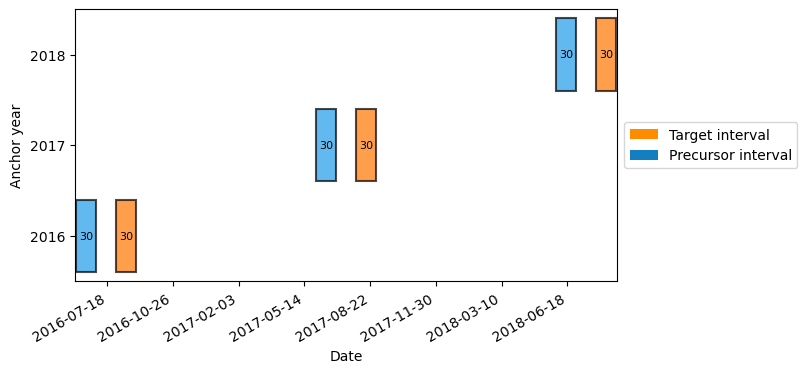

In [12]:
# map calendar to data
calendar.map_to_data(precursor_field)
calendar.visualize(show_length=True)

#### Train-test split based on the anchor years (70%/30% split)
This can be taken as the "outer cross-validation layer".

In [22]:
# get 70% of instance as training
years = calendar.get_intervals().index
train_samples = round(len(years) * 0.7)
start_year = years[-1]

#### Fit preprocessor with training samples and preprocess data
Remove trend and take anomalies for the precursor field.

In [28]:
# create preprocessor
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    detrend="linear",
    subtract_climatology=True,
)

# fit preprocessor with training data
preprocessor.fit(precursor_field.sel(time=slice(str(start_year),
                                                str(start_year + train_samples - 1))))

In [32]:
# preprocess the whole precursor field
precursor_field_prep = preprocessor.transform(precursor_field)

#### Resample data to the calendar